In [1]:
%%capture

from lmi import lmi
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm
import torch
from scipy.stats import kendalltau

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
def generate_gaussian_dataset(ambient, intrinsic, nuisance, antidiag, samples=10**3):
    
    assert (intrinsic*2)+nuisance <= ambient, "Dimensionality not adding up"
    
    X_nuisance = np.random.normal(size=(samples, nuisance))
    Y_nuisance = np.random.normal(size=(samples, nuisance))


    cov = np.array([[6, antidiag], [antidiag, 3.5]])
    
    pts = [np.random.multivariate_normal([0, 0], cov, 
                                         size=samples) for i in range(intrinsic)]
    
    pts = np.hstack(pts)
    
    # one copy of the intrinsic dimensions
    Xs = pts[:, [i for i in range(0, 2*intrinsic, 2)]]
    Ys = pts[:, [i for i in range(1, 2*intrinsic, 2)]]
    
    # then randomly sample them to make up the rest of the dimensions
    X_redundant = pts[:, np.random.choice(range(0, 2*intrinsic, 2), 
                                   size = (ambient-(intrinsic+nuisance)))]
    
    Y_redundant = pts[:, np.random.choice(range(1, 2*intrinsic, 2), 
                               size = (ambient-(intrinsic+nuisance)))]
    
    Xs = np.hstack((Xs, X_redundant, X_nuisance))
    Ys = np.hstack((Ys, Y_redundant, Y_nuisance))
    
    return Xs, Ys

def mi_from_rho(rho, intrinsic):
    return -0.5*np.log2((1-(rho/(np.sqrt(6*3.5)))**2))*intrinsic

def rho_from_mi(mi, intrinsic):
    return np.sqrt(6*3.5) * np.sqrt(1 - 2**(-2*mi/intrinsic))

In [3]:
ambient = 1000
intrinsic = 10
nuisance = (ambient - intrinsic)//2
true_mi = 1
antidiag = rho_from_mi(true_mi, intrinsic)
N_samples = 5*10**3


d = {
    "Latent size" : [],
    "Model loss" : [],
    "Estimate" : [],
    "True MI" : []
}

for trials in range(1):
    
    Xs, Ys = generate_gaussian_dataset(ambient, intrinsic, 
                                       nuisance, 
                                       antidiag,
                                      samples=N_samples)
    
    # rescale
    Xs_t = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
    Ys_t = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()

    Xs_t = torch.clip(Xs_t, min=-10, max=10)
    Ys_t = torch.clip(Ys_t, min=-10, max=10)
    
    for N_dims in tqdm(range(1, 16)):

        pmis, embedding, model = lmi.lmi(Xs, Ys, N_dims=N_dims)

        loss = model.learning_loss(Xs_t, Ys_t).detach().cpu().item()
    
        d['Latent size'].append(N_dims)
        d['Model loss'].append(loss)
        d['Estimate'].append(np.nanmean(pmis))
        d['True MI'].append(1)
    

  0%|          | 0/15 [00:00<?, ?it/s]

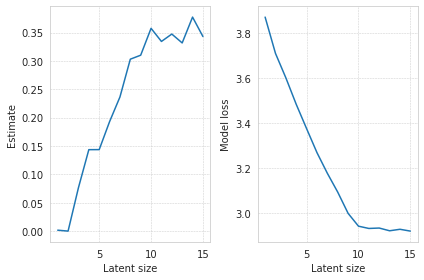

In [4]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (6, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

df = pd.DataFrame(d)

fig, ax = plt.subplots(1, 2)
sns.lineplot(df, x='Latent size', y='Estimate', ax=ax[0])
sns.lineplot(df, x='Latent size', y='Model loss', ax=ax[1],)
fig.tight_layout()
plt.show()

In [5]:
ambient = 1000
intrinsic = 6
nuisance = (ambient - intrinsic)//2
true_mi = 1
antidiag = rho_from_mi(true_mi, intrinsic)
N_samples = 5*10**3


d6 = {
    "Latent size" : [],
    "Model loss" : [],
    "Estimate" : [],
    "True MI" : []
}

for trials in range(1):
    
    Xs, Ys = generate_gaussian_dataset(ambient, intrinsic, 
                                       nuisance, 
                                       antidiag,
                                      samples=N_samples)
    
    # rescale
    Xs_t = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
    Ys_t = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()

    Xs_t = torch.clip(Xs_t, min=-10, max=10)
    Ys_t = torch.clip(Ys_t, min=-10, max=10)
    
    for N_dims in tqdm(range(1, 16)):

        pmis, embedding, model = lmi.lmi(Xs, Ys, N_dims=N_dims)

        loss = model.learning_loss(Xs_t, Ys_t).detach().cpu().item()
    
        d6['Latent size'].append(N_dims)
        d6['Model loss'].append(loss)
        d6['Estimate'].append(np.nanmean(pmis))
        d6['True MI'].append(1)
    

  0%|          | 0/15 [00:00<?, ?it/s]

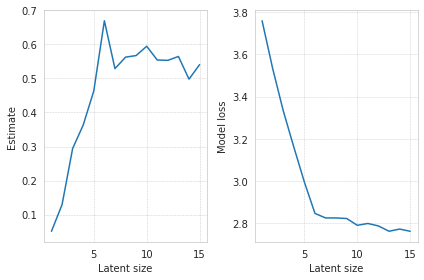

In [6]:
df6 = pd.DataFrame(d6)

fig, ax = plt.subplots(1, 2)
sns.lineplot(df6, x='Latent size', y='Estimate', ax=ax[0])
sns.lineplot(df6, x='Latent size', y='Model loss', ax=ax[1],)
fig.tight_layout()
plt.show()

In [7]:
pxf = pd.read_csv('../data/ProtT5_embeddings/OP_kinases.csv', index_col=0)
kinases = [x for x in pxf.keys() if x[:7] == 'Kinase_']
targets = [x for x in pxf.keys() if x[:7] == 'Target_']

Xs, Ys = pxf[kinases], pxf[targets]

Xs_t = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
Ys_t = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()

Xs_t = torch.clip(Xs_t, min=-10, max=10)
Ys_t = torch.clip(Ys_t, min=-10, max=10)

In [8]:
d2 = {
    "Latent size" : [],
    "Estimate" : [],
    "Model loss" : [],
}

for trials in range(1):
    
    for N_dims in tqdm(range(1, 16)):
    
        pmis, embedding, model = lmi.lmi(Xs, Ys, N_dims=N_dims)

        loss = model.learning_loss(Xs_t, Ys_t).detach().cpu().item()
    
        d2['Latent size'].append(N_dims)
        d2['Model loss'].append(loss)
        d2['Estimate'].append(np.nanmean(pmis))

  0%|          | 0/15 [00:00<?, ?it/s]

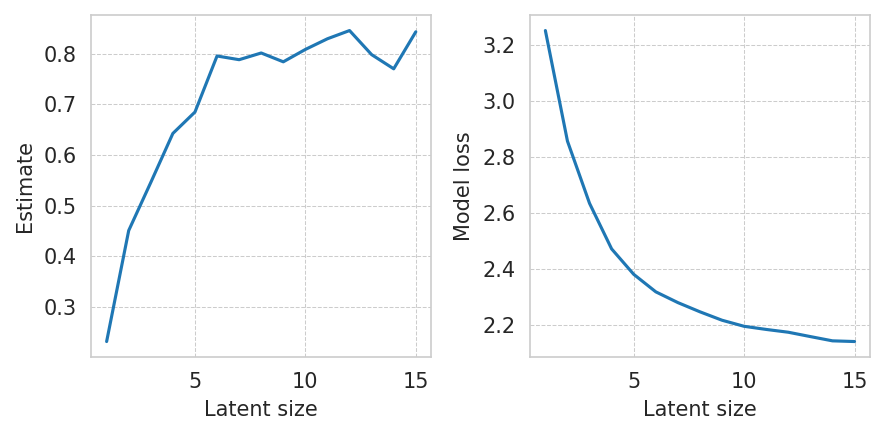

In [9]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (6, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

df2 = pd.DataFrame(d2)
fig, ax = plt.subplots(1, 2)
sns.lineplot(df2, x='Latent size', y='Estimate', ax=ax[0])
sns.lineplot(df2, x='Latent size', y='Model loss', ax=ax[1],)
fig.tight_layout()
plt.show()